In [1]:
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed

from rsq import AgglomerativeEnsemble
from rsq.helpers import stratified_sample, few_shot_sample

import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons
from sklearn.neighbors import KNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading

def exp(n_unlabeled=100, n_labeled_per_class=1, noise=0.1, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    accuracies = np.zeros(2)
    
    n_labeled=2*n_labeled_per_class
    
    X, y = make_moons(10000, noise=noise)
    perm = np.random.choice(10000, 10000, replace=False)

    X_labeled_1 = X[perm][np.where(y[perm] == 0)[0][:n_labeled_per_class]]
    X_labeled_2 = X[perm][np.where(y[perm] == 1)[0][:n_labeled_per_class]]
    X_labeled = np.concatenate((X_labeled_1, X_labeled_2), axis=0)
    
    del X, y
    
    y_labeled = np.concatenate((np.zeros(n_labeled_per_class), np.ones(n_labeled_per_class)))
    
    X, y = make_moons(20000, noise=noise)
    X_unlabeled = X[:n_unlabeled]
    y_unlabeled = y[:n_unlabeled]
        
    X_test, y_test = make_moons(1000, noise=noise)
    
    del X, y
    
#     clf=SVC()
#     clf.fit(X_labeled, y_labeled)
#     y_hat=clf.predict(X_test)
#     accuracies[1] = (y_test == y_hat).mean()
    
    
#     clf=DecisionTreeClassifier()
#     clf.fit(X_labeled, y_labeled)
#     y_hat=clf.predict(X_test)
#     accuracies[2] = (y_test == y_hat).mean()
    
    
    clf=KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    clf.fit(X_labeled, y_labeled)
    y_hat=clf.predict(X_test)
    accuracies[1] = (y_test == y_hat).mean()

    
    y_ = -1 * np.ones(n_labeled + n_unlabeled)
    y_[:n_labeled] = y_labeled.copy()

    n_neighbors = max([1, int(np.math.floor(np.log(len(y_))))])
    clf=AgglomerativeEnsemble(n_estimators=1, p_inbag=1, affinity='euclidean', linkage='single', n_neighbors=1, gem_p=128)
    clf.fit(np.concatenate((X_labeled, X_unlabeled), axis=0), y_)
    y_hat=clf.predict(X_test)
    accuracies[0] = (y_test == y_hat).mean()
    
#     clf=LabelPropagation(n_neighbors=1)
#     clf.fit(np.concatenate((X_labeled, X_unlabeled), axis=0), y_)
#     y_hat=clf.predict(X_test)
#     accuracies[4] = (y_test == y_hat).mean()
    
#     clf=LabelSpreading(n_neighbors=1)
#     clf.fit(np.concatenate((X_labeled, X_unlabeled), axis=0), y_)
#     y_hat=clf.predict(X_test)
#     accuracies[5] = (y_test == y_hat).mean()
    
        
    print(n_unlabeled, n_labeled, accuracies)

    return accuracies

In [52]:
n_labeled=1
n_labeled_list = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500])
condensed_func = lambda x: exp(x, n_labeled, 0.001)

n_mc=180
n_cores=90

algos = ['HADR', '1-NN']

func_tuples = []
for n_labeled_ in n_labeled_list:
    for i in range(n_mc):
        func_tuples.append(n_labeled_)
        
accuracies_list = Parallel(n_jobs=n_cores)(delayed(condensed_func)(x) for x in func_tuples)

In [53]:
accuracies=np.zeros((len(algos), len(n_labeled_list), n_mc))

for i in range(len(n_labeled_list)):
    for j in range(n_mc):
        accuracies[0, i, j] = accuracies_list[int(i*n_mc + j)][0]
        accuracies[1, i, j] = accuracies_list[int(i*n_mc + j)][1]
#         accuracies[2, i, j] = accuracies_list[int(i*n_mc + j)][2]
#         accuracies[3, i, j] = accuracies_list[int(i*n_mc + j)][3]
#         accuracies[4, i, j] = accuracies_list[int(i*n_mc + j)][4]
#         accuracies[5, i, j] = accuracies_list[int(i*n_mc + j)][5]

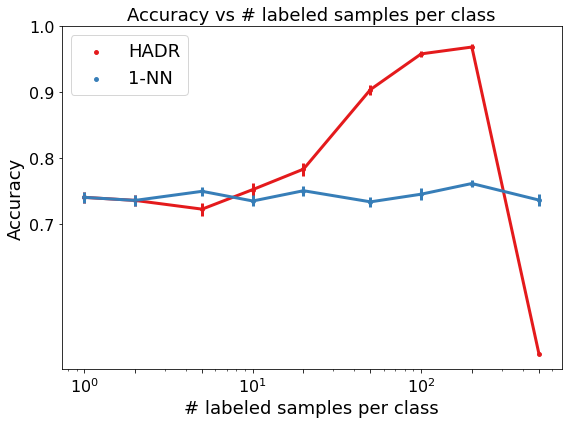

In [54]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

colors= sns.color_palette('Set1', n_colors=len(algos))

ax.set_xscale('log')
for i, algo in enumerate(algos):
    if i >= 5:
        ci = i+1
    else:
        ci = i
    ax.scatter(n_labeled_list, np.mean(accuracies, axis=-1)[i], color=colors[ci], label=algo, s=15)
    ax.errorbar(n_labeled_list, np.mean(accuracies, axis=-1)[i], color=colors[ci], lw=3, yerr=np.std(accuracies, axis=-1)[i] / np.sqrt(n_mc))

#     for j, n_labeled in enumerate(n_labeled_list):
#         if j > 0:
#             continue
#         ax.scatter([n_labeled + (i-1)/2.5]*n_mc, accuracies[i, j], color=colors[i], s=1, alpha=1)
    
    
ax.legend(fontsize=18)
ax.set_xlabel('# labeled samples per class', fontsize=18)
ax.set_ylabel('Accuracy', fontsize=18)
ax.set_title('Accuracy vs # labeled samples per class', fontsize=18)


    
ax.set_yticks([0.7,0.8,0.9,1])
ax.tick_params(labelsize=16)
ax.set_xticks(n_labeled_list)

plt.tight_layout()
# plt.savefig('figures/moons_unlabeled.pdf')

In [ ]:
n_unlabeled=500
n_labeled_per_class=1
noise=0.05

n_labeled=2*n_labeled_per_class

X, y = make_moons(10000, noise=noise)
perm = np.random.choice(10000, 10000, replace=False)

X_labeled_1 = X[perm][np.where(y[perm] == 0)[0][:n_labeled_per_class]]
X_labeled_2 = X[perm][np.where(y[perm] == 1)[0][:n_labeled_per_class]]
X_labeled = np.concatenate((X_labeled_1, X_labeled_2), axis=0)

del X, y

y_labeled = np.concatenate((np.zeros(n_labeled_per_class), np.ones(n_labeled_per_class)))

X, y = make_moons(10000, noise=noise)
X_unlabeled = X[:n_unlabeled]
y_unlabeled = y[:n_unlabeled]

X_test, y_test = make_moons(1000, noise=noise)

#     clf=SVC()
#     clf.fit(X_labeled, y_labeled)
#     y_hat=clf.predict(X_test)
#     accuracies[1] = (y_test == y_hat).mean()


#     clf=DecisionTreeClassifier()
#     clf.fit(X_labeled, y_labeled)
#     y_hat=clf.predict(X_test)
#     accuracies[2] = (y_test == y_hat).mean()


fig, ax = plt.subplots(1,2)

clf=KNeighborsClassifier(n_neighbors=1, metric='euclidean')
clf.fit(X_labeled, y_labeled)
y_hat=clf.predict(X_test)
accuracies[1] = (y_test == y_hat).mean()

ax[0].scatter(X_test[:, 0], X_test[:,1], c=y_hat)


y_ = -1 * np.ones(n_labeled + n_unlabeled)
y_[:n_labeled] = y_labeled.copy()

n_neighbors = max([1, int(np.math.floor(np.log(len(y_))))])
clf=AgglomerativeClassifier(affinity='euclidean', linkage='single', n_neighbors=1, gem_p=128)
clf.fit(np.concatenate((X_labeled, X_unlabeled), axis=0), y_)
y_hat=clf.predict(X_test)
accuracies[0] = (y_test == y_hat).mean()
ax[1].scatter(X_test[:, 0], X_test[:,1], c=y_hat)

In [90]:
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors 

from aggclass.helpers import get_decision_paths, gem, get_tree_distances

from scipy.special import softmax

class AgglomerativeClassifier:
    def __init__(self, n_clusters=2, affinity='cosine', linkage='average',
                n_neighbors=1,
                 max_tree_distance=None,
                 soft_max_multiplier=1,
                 gem_p=1,
                classes=None):
        
        self.n_clusters = n_clusters
        self.affinity = affinity
        self.linkage = linkage
        
        self.n_neighbors = n_neighbors
                
        self.classes_ = classes
        
        self.max_tree_distance=max_tree_distance
        self.soft_max_multiplier=soft_max_multiplier
        
        self.gem_p = gem_p
        
        
    def fit(self, X, y):
        self.n, d = X.shape

        self.labeled_inds = np.where(y != -1)[0]
                
        if self.classes_ is None:
            self.classes_ = np.unique(y[self.labeled_inds])
            
        if -1 in self.classes_:
            self.classes_ = self.classes_[1:]
        
        if self.linkage=='gini' or self.linkage=='bonferroni':
            self.model = Genie(n_clusters=self.n_clusters, 
                compute_all_cuts=False,
                affinity=self.affinity, 
                exact=True,
                compute_full_tree=True)

            self.model.fit(X)
        else:  
            if self.linkage != 'ward':
                pairwise_distances_ = pairwise_distances(X, metric=self.affinity, n_jobs=1)

                self.model = AgglomerativeClustering(n_clusters=self.n_clusters,
                    affinity='precomputed', 
                    linkage=self.linkage,
                    compute_full_tree=True,
                    ).fit(pairwise_distances_)

                
                del pairwise_distances_
            else:
                self.model = AgglomerativeClustering(n_clusters=self.n_clusters, 
                    affinity=self.affinity, 
                    linkage=self.linkage,
                    compute_full_tree=True
                    )
                self.model.fit(X)
                    
        self.nn = NearestNeighbors(n_neighbors=self.n_neighbors, metric=self.affinity)
        self.nn.fit(X)

        
        labeled_inds_by_class = [np.where(y[self.labeled_inds] == c)[0] for c in self.classes_]
        decision_paths, counts = get_decision_paths(self.n, self.model.children_)
        
        self._get_tree_distances(decision_paths, counts)        
        self._get_similarities_to_classes(labeled_inds_by_class)

        return self
        
                                    
    def _get_tree_distances(self, decision_paths, counts):
        self.tree_distances = get_tree_distances(self.n, decision_paths, self.labeled_inds, counts, self.max_tree_distance)
        self.scores = np.log(self.tree_distances + 1) + 1
        self.scores = 1 / self.scores
        self.scores = softmax(self.soft_max_multiplier * self.scores, axis=1)
        
        
    def _get_similarities_to_classes(self, labeled_inds_by_class):
        self.similarities_to_classes = np.zeros((self.n, len(self.classes_)))
        
        for i, ibc in enumerate(labeled_inds_by_class):
            self.similarities_to_classes[:, i] = gem(self.scores[:, ibc].T, p=self.gem_p)
                                              
        self.similarities_to_classes = softmax(self.similarities_to_classes, axis=1)
        
        
    def predict_proba(self, X):
        _, neighbor_inds = self.nn.kneighbors(X)
        scores = np.mean(self.similarities_to_classes[neighbor_inds], axis=1)
        return softmax(scores, axis=1)
    
    
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

In [88]:
clf.scores

array([[0.67877265, 0.32122735],
       [0.32122735, 0.67877265],
       [0.51028202, 0.48971798],
       ...,
       [0.48399513, 0.51600487],
       [0.51188424, 0.48811576],
       [0.50140763, 0.49859237]])